In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
# Reading CSV files
file_path = "bank-full.csv"
data = pd.read_csv(file_path)
#I'll define an object df and assign data to df, so that I can differentiate between them, or back them up.
df = data

In [2]:
#See the data types of columns in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
#Display categorical variables 
df.select_dtypes(include=["object","bool"]).describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [4]:
#Display continuous variable
pd.options.display.float_format = '{:.2f}'.format 
df.select_dtypes(include=["int64","float64"]).describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00
mean,40.94,1362.27,15.81,258.16,2.76,40.20,0.58
std,10.62,3044.77,8.32,257.53,3.10,100.13,2.30
min,18.00,-8019.00,1.00,0.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1428.00,21.00,319.00,3.00,-1.00,0.00
max,95.00,102127.00,31.00,4918.00,63.00,871.00,275.00


In [5]:
# Identify feature types
target = 'y'
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != target]
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [6]:
# Function to Calculate WoE and IV
eps = 0.0001
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].value_counts().unstack().fillna(0)
    if 'yes' not in grouped.columns or 'no' not in grouped.columns:
        grouped = grouped.reindex(columns=['no', 'yes'], fill_value=0)

    grouped['dist_good'] = grouped['yes'] / grouped['yes'].sum()
    grouped['dist_bad'] = grouped['no'] / grouped['no'].sum()
    grouped['woe'] = np.log((grouped['dist_good'] + eps) / (grouped['dist_bad'] + eps))
    grouped['iv'] = (grouped['dist_good'] - grouped['dist_bad']) * grouped['woe']
    iv = grouped['iv'].sum()
    return grouped[['woe']], iv

In [7]:
# Smart binning for numerical features
def smart_bin_numerical(df, col, q=10):
    try:
        df[f'{col}_bin'] = pd.qcut(df[col], q=q, duplicates='drop')
        return df, f'{col}_bin'
    except ValueError:
        unique_vals = df[col].nunique()
        if unique_vals > 1:
            bins = min(q, unique_vals)
            df[f'{col}_bin'] = pd.qcut(df[col], q=bins, duplicates='drop')
            return df, f'{col}_bin'
        else:
            return df, None

In [8]:
# Store WoE values
woe_results = {}
iv_summary = {}
woe_transformed = pd.DataFrame()

In [9]:
# Transform categorical features
for col in cat_cols:
    try:
        woe, iv = calculate_woe_iv(df, col, target)
        iv_summary[col] = iv
        woe_results[col] = woe
        woe_map = woe['woe'].to_dict()
        woe_transformed[col + '_woe'] = df[col].map(woe_map)
    except Exception as e:
        print(f"Error in {col}: {e}")

In [10]:
# Transform numerical features
for col in num_cols:
    try:
        df, binned_col = smart_bin_numerical(df, col)
        if binned_col:
            woe, iv = calculate_woe_iv(df, binned_col, target)
            iv_summary[col] = iv
            woe_results[col] = woe
            woe_map = woe['woe'].to_dict()
            woe_transformed[col + '_woe'] = df[binned_col].map(woe_map)
    except Exception as e:
        print(f"Error in {col}: {e}")

C:\Users\ntt68\AppData\Local\Temp\ipykernel_18704\2599617828.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts().unstack().fillna(0)
C:\Users\ntt68\AppData\Local\Temp\ipykernel_18704\2599617828.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts().unstack().fillna(0)
C:\Users\ntt68\AppData\Local\Temp\ipykernel_18704\2599617828.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

In [11]:
# Add target to the transformed set
woe_transformed[target] = df[target]

In [12]:
# Show final IV summary
iv_df = pd.DataFrame.from_dict(iv_summary, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
print("📊 Information Value Summary:")
print(iv_df)

📊 Information Value Summary:
            IV
duration  1.60
poutcome  0.51
month     0.43
contact   0.30
housing   0.19
job       0.16
age       0.12
previous  0.11
balance   0.10
campaign  0.07
day       0.06
loan      0.05
education 0.05
marital   0.04
pdays     0.01
default   0.01


In [13]:
# Show transformed dataset sample
print("Transformed Dataset (with WoE values):")
print(woe_transformed)

Transformed Dataset (with WoE values):
       job_woe  marital_woe  education_woe  default_woe  housing_woe  \
0         0.19        -0.16           0.29         0.01        -0.46   
1        -0.06         0.28          -0.12         0.01        -0.46   
2        -0.38        -0.16          -0.12         0.01        -0.46   
3        -0.52        -0.16           0.17         0.01        -0.46   
4         0.01         0.28           0.17         0.01         0.41   
...        ...          ...            ...          ...          ...   
45206    -0.06        -0.16           0.29         0.01         0.41   
45207     0.80         0.02          -0.34         0.01         0.41   
45208     0.80        -0.16          -0.12         0.01         0.41   
45209    -0.52        -0.16          -0.12         0.01         0.41   
45210    -0.38        -0.16          -0.12         0.01         0.41   

       loan_woe  contact_woe  month_woe  poutcome_woe age_woe balance_woe  \
0          0.09    

In [14]:
# Filter features with IV > 0.02 (customize threshold)
selected_features = iv_df[iv_df['IV'] > 0.02].index.tolist()

print("Selected Features Based on IV:")
for feat in selected_features:
    print(f"{feat} (IV: {iv_df.loc[feat, 'IV']:.4f})")

Selected Features Based on IV:
duration (IV: 1.6025)
poutcome (IV: 0.5134)
month (IV: 0.4341)
contact (IV: 0.3002)
housing (IV: 0.1886)
job (IV: 0.1554)
age (IV: 0.1159)
previous (IV: 0.1077)
balance (IV: 0.1018)
campaign (IV: 0.0675)
day (IV: 0.0569)
loan (IV: 0.0548)
education (IV: 0.0501)
marital (IV: 0.0401)


In [15]:
# Filter features with IV > threshold (0.02)
iv_threshold = 0.02
selected_features = iv_df[iv_df['IV'] > iv_threshold].index.tolist()

# Convert original feature names to WoE-transformed names
selected_columns = [feat + '_woe' for feat in selected_features if feat + '_woe' in woe_transformed.columns]

# Create a clean modeling dataset
model_data = woe_transformed[selected_columns + [target]]

# Display result
print("Final Modeling Dataset (with selected WoE features):")
print(model_data.head())

Final Modeling Dataset (with selected WoE features):
  duration_woe  poutcome_woe  month_woe  contact_woe  housing_woe  job_woe  \
0         0.06         -0.27      -0.61        -1.14        -0.46     0.19   
1        -0.59         -0.27      -0.61        -1.14        -0.46    -0.06   
2        -2.34         -0.27      -0.61        -1.14        -0.46    -0.38   
3        -1.51         -0.27      -0.61        -1.14        -0.46    -0.52   
4        -0.29         -0.27      -0.61        -1.14         0.41     0.01   

  age_woe previous_woe balance_woe campaign_woe day_woe  loan_woe  \
0    0.65        -0.11        0.41         0.14    0.27      0.09   
1   -0.30        -0.11       -0.27         0.14    0.27      0.09   
2   -0.13        -0.11       -0.53         0.14    0.27     -0.61   
3   -0.29        -0.11        0.23         0.14    0.27      0.09   
4   -0.13        -0.11       -0.53         0.14    0.27      0.09   

   education_woe  marital_woe   y  
0           0.29        -0.

In [16]:
# Convert 'yes'/'no' target to binary
model_data.loc[:, 'y'] = model_data['y'].map({'yes': 1, 'no': 0})
model_data

,duration_woe,poutcome_woe,month_woe,contact_woe,housing_woe,job_woe,age_woe,previous_woe,balance_woe,campaign_woe,day_woe,loan_woe,education_woe,marital_woe,y
0,0.06,-0.27,-0.61,-1.14,-0.46,0.19,0.65,-0.11,0.41,0.14,0.27,0.09,0.29,-0.16,0
1,-0.59,-0.27,-0.61,-1.14,-0.46,-0.06,-0.30,-0.11,-0.27,0.14,0.27,0.09,-0.12,0.28,0
2,-2.34,-0.27,-0.61,-1.14,-0.46,-0.38,-0.13,-0.11,-0.53,0.14,0.27,-0.61,-0.12,-0.16,0
3,-1.51,-0.27,-0.61,-1.14,-0.46,-0.52,-0.29,-0.11,0.23,0.14,0.27,0.09,0.17,-0.16,0
4,-0.29,-0.27,-0.61,-1.14,0.41,0.01,-0.13,-0.11,-0.53,0.14,0.27,0.09,0.17,0.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,1.84,-0.27,-0.16,0.28,0.41,-0.06,-0.29,-0.11,0.09,-0.05,-0.23,0.09,0.29,-0.16,1
45207,0.69,-0.27,-0.16,0.28,0.41,0.80,0.65,-0.11,0.23,0.14,-0.23,0.09,-0.34,0.02,1
45208,1.84,2.62,-0.16,0.28,0.41,0.80,0.65,0.95,0.37,-0.44,-0.23,0.09,-0.12,-0.16,1
45209,0.69,-0.27,-0.16,0.16,0.41,-0.52,0.65,-0.11,0.03,-0.29,-0.23,0.09,-0.12,-0.16,0


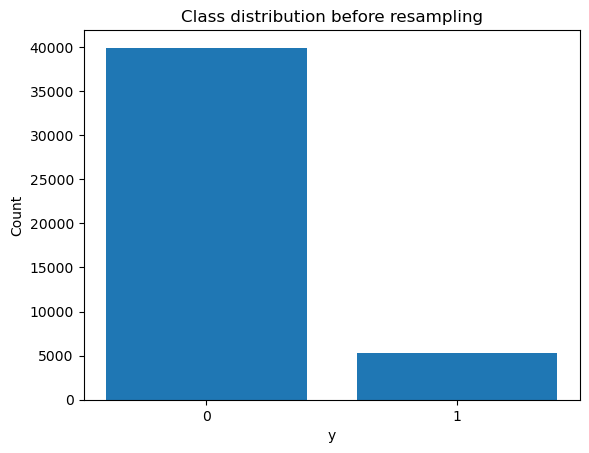

y
0    39922
1     5289
Name: count, dtype: int64


In [17]:
# Convert Target column to numeric data
model_data = model_data.apply(pd.to_numeric, errors='coerce')

# Count the number of both positive and negative decison variables
y_count = model_data['y'].value_counts()
plt.bar(y_count.index, y_count.values)
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Class distribution before resampling')
plt.xticks(y_count.index, ['0', '1'])
#plt.savefig('image/distribution_original.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()
print(y_count)

In [18]:
from sklearn.model_selection import train_test_split

# Define features and target
X = model_data.drop(columns=['y']) 
y = model_data['y']

# Split 80% for training set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Split the remaining half - half for validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/2, stratify=y_temp, random_state=42, shuffle=True)

# Print the information
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 36168
Validation size: 4521
Test size: 4522


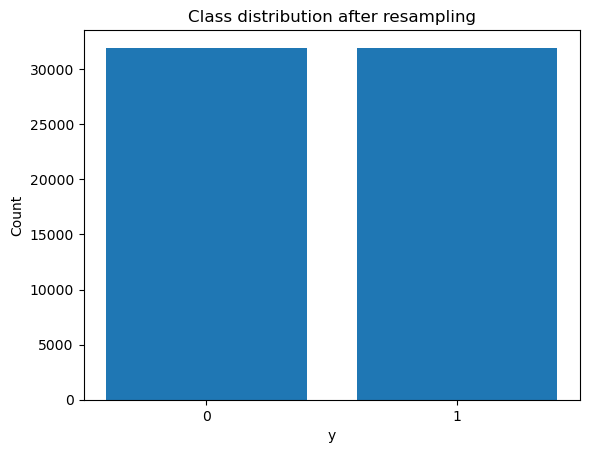

Class distribution after resampling:
y
0    31937
1    31937
Name: count, dtype: int64


In [19]:
from imblearn.over_sampling import RandomOverSampler

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling on the training set
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Count the number of both positive and negative decison variables
y_count_resampled = y_train_resampled.value_counts()
plt.bar(y_count_resampled.index, y_count_resampled.values)
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Class distribution after resampling')
plt.xticks(y_count_resampled.index, ['0', '1'])
#plt.savefig('image/distribution_resampled.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# Verify class distribution in the resampled training data
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      3992
           1       0.45      0.81      0.58       529

    accuracy                           0.86      4521
   macro avg       0.71      0.84      0.75      4521
weighted avg       0.91      0.86      0.88      4521



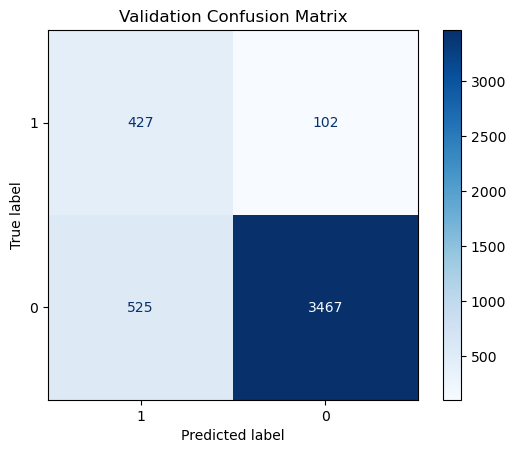

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      3993
           1       0.45      0.78      0.57       529

    accuracy                           0.86      4522
   macro avg       0.71      0.83      0.75      4522
weighted avg       0.91      0.86      0.88      4522



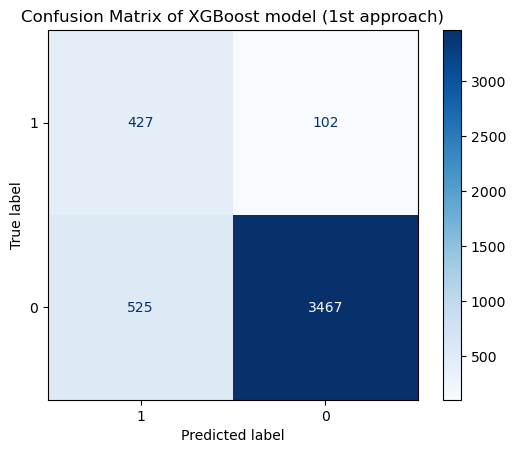

In [20]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train the XGBoost model
xgboost_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgboost_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on the validation set
y_val_pred = xgboost_model.predict(X_val)

# Print classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix for validation
confusion_matrix_valid = confusion_matrix(y_val, y_val_pred, labels=[1, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_valid, display_labels=[1, 0])
cm_display.plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()

# Evaluate on the test set
y_test_pred = xgboost_model.predict(X_test)
report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(report)

# Save to text file
with open("xgboost_classification_report.txt", "w") as f:
    f.write(report)

# Confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_val, y_val_pred, labels=[1, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test, display_labels=[1, 0])
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix of XGBoost model (1st approach)")
plt.savefig('image/confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

AUC (Test Set): 0.9142


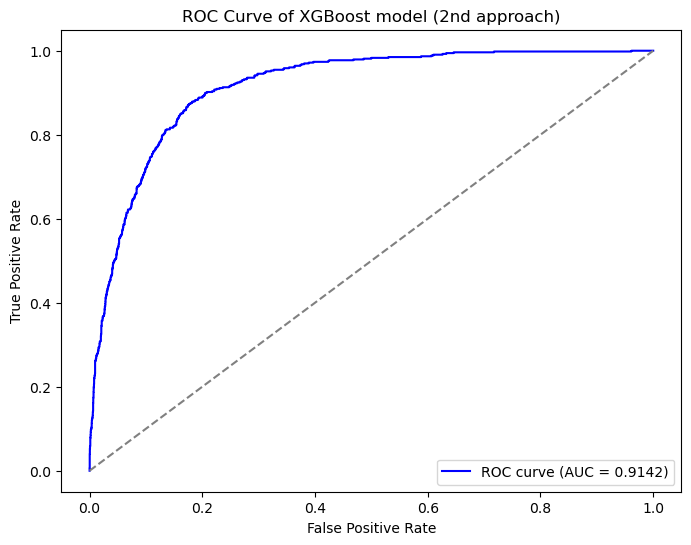

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the validation set
y_test_prob = xgboost_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class (class 1)

# Calculate AUC for the test set
auc_test = roc_auc_score(y_test, y_test_prob)
print(f"AUC (Test Set): {auc_test:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label = f'ROC curve (AUC = {auc_test:.4f})', color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of XGBoost model (2nd approach)')
plt.legend(loc='lower right')
plt.savefig('image/ROC_xgboost.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

In [22]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
accuracy

0.8633348076072535